In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

import xgboost as xgb
from transformers import T5Tokenizer, T5Model
import torch
from transformers import T5Tokenizer, T5EncoderModel
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

def preprocess_data_with_bert(file_path, batch_size=32, max_length=512, n_components=100):
    # Load the data
    df = pd.read_excel(file_path)
    
    # Ensure that 'Text' column is used as the independent variable
    df['Text'] = df['Text'].astype(str)
    
    # Drop any rows where 'Text' or 'Type' is NaN
    df.dropna(subset=['Text', 'Type'], inplace=True)
    
    # Define features and labels
    X = df['Text'].tolist()  # Convert the text to a list
    y = df['Type']
    
    # Encode the labels into numeric values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Load pre-trained BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased').to('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Generate BERT embeddings for the texts in batches
    def get_bert_embeddings(texts):
        all_embeddings = []
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(model.device)
            with torch.no_grad():  # Disable gradient calculations for inference
                outputs = model(**inputs)
                batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean of all token embeddings
                all_embeddings.append(batch_embeddings.cpu())
        return torch.cat(all_embeddings, dim=0)
    
    # Generate embeddings for all the text data
    X_embeddings = get_bert_embeddings(X)
    
    # Convert PyTorch tensors to NumPy arrays
    X_embeddings = X_embeddings.numpy()
    
    # Apply PCA for dimensionality reduction
    print("Applying PCA for dimensionality reduction...")
    pca = PCA(n_components=n_components, random_state=42)
    X_embeddings_reduced = pca.fit_transform(X_embeddings)
    
    # Split the data into training and test sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_embeddings_reduced, y_encoded, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder, pca

# Run the function
file_path = 'test.xlsx'
X_train, X_test, y_train, y_test, label_encoder, pca = preprocess_data_with_bert(file_path)

100%|█████████████████████████████████████████| 109/109 [00:31<00:00,  3.46it/s]


In [2]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, label_encoder, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [25]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

def preprocess_data_with_bert(file_path, batch_size=32, max_length=512):
    # Load the data
    df = pd.read_excel(file_path)
    
    # Ensure that 'Text' column is used as the independent variable
    df['Text'] = df['Text'].astype(str)
    
    # Drop any rows where 'Text' or 'Type' is NaN
    df.dropna(subset=['Text', 'Type'], inplace=True)
    
    # Define features and labels
    X = df['Text'].tolist()  # Convert the text to a list
    y = df['Type']
    
    # Encode the labels into numeric values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Load pre-trained BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased').to('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Generate BERT embeddings for the texts in batches
    def get_bert_embeddings(texts):
        all_embeddings = []
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(model.device)
            with torch.no_grad():  # Disable gradient calculations for inference
                outputs = model(**inputs)
                batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean of all token embeddings
                all_embeddings.append(batch_embeddings.cpu())
        return torch.cat(all_embeddings, dim=0)
    
    # Generate embeddings for all the text data
    X_embeddings = get_bert_embeddings(X)
    
    # Convert PyTorch tensors to NumPy arrays
    X_embeddings = X_embeddings.numpy()
    
    # Split the data into training and test sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y_encoded, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder

# Run the function
file_path = 'test.xlsx'
X_train, X_test, y_train, y_test, label_encoder = preprocess_data_with_bert(file_path)


100%|█████████████████████████████████████████| 109/109 [00:32<00:00,  3.39it/s]


Best Hyperparameters found by RandomizedSearchCV: {'kernel': 'poly', 'gamma': 0.01, 'degree': 4, 'coef0': 0.5, 'C': 0.46415888336127775}
Results for SVM after Randomized Hyperparameter Tuning:
Training Accuracy: 0.8639
Test Accuracy: 0.7409
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.65      0.56      0.60       323
    Question       0.91      0.86      0.89       219
   Statement       0.72      0.81      0.76       504

    accuracy                           0.74      1046
   macro avg       0.76      0.74      0.75      1046
weighted avg       0.74      0.74      0.74      1046

Confusion Matrix for Training Set:


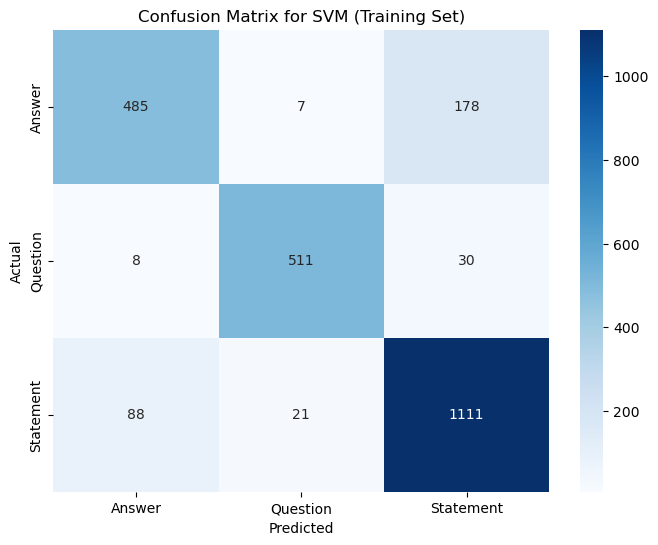

Confusion Matrix for Test Set:


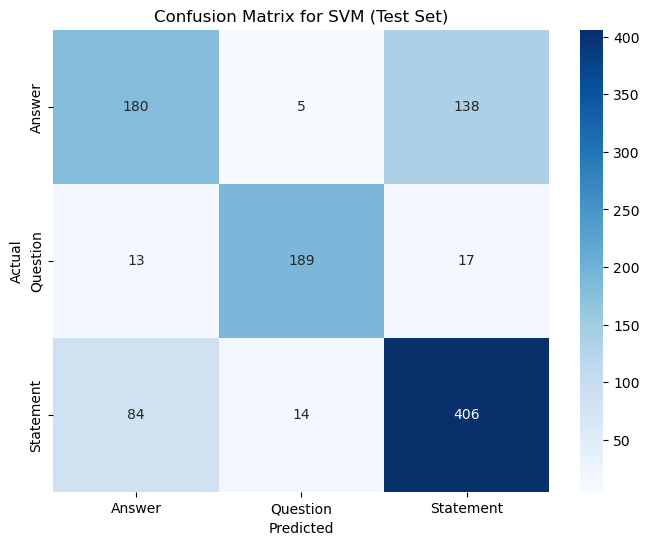

In [6]:


# Function to train and evaluate SVM with hyperparameter tuning (RandomizedSearchCV)
def run_svm_random(X_train, X_test, y_train, y_test, label_encoder):
    # Define hyperparameter distribution for RandomizedSearchCV
    param_dist = {
        'C': np.logspace(-3, 3, 10),        # C values on a log scale
        'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],  # Adding specific gamma values to search
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'degree': [2, 3, 4],                # Only applicable for 'poly' kernel
        'coef0': [0, 0.1, 0.5, 1]           # Only applicable for 'poly' and 'sigmoid' kernels
    }

    # Initialize SVM and RandomizedSearchCV for hyperparameter tuning
    model = SVC()
    random_search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    
    # Train the model using RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Get the best model after tuning
    best_model = random_search.best_estimator_
    
    # Predictions on the test set
    y_pred_test = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = best_model.predict(X_train)
    train_accuracy = best_model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Best Hyperparameters found by RandomizedSearchCV:", random_search.best_params_)
    print("Results for SVM after Randomized Hyperparameter Tuning:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep)
    
    # Plot confusion matrix for the training set
    print("Confusion Matrix for Training Set:")
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "SVM (Training Set)")
    
    # Plot confusion matrix for the test set
    print("Confusion Matrix for Test Set:")
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "SVM (Test Set)")

# Call the updated function
run_svm_random(X_train, X_test, y_train, y_test, label_encoder)


Results for Decision Tree:
Training Accuracy: 0.9926
Test Accuracy: 0.6338
Classification Report:
              precision    recall  f1-score   support

      Answer       0.53      0.56      0.55       323
    Question       0.69      0.71      0.70       219
   Statement       0.68      0.65      0.66       504

    accuracy                           0.63      1046
   macro avg       0.63      0.64      0.64      1046
weighted avg       0.64      0.63      0.63      1046



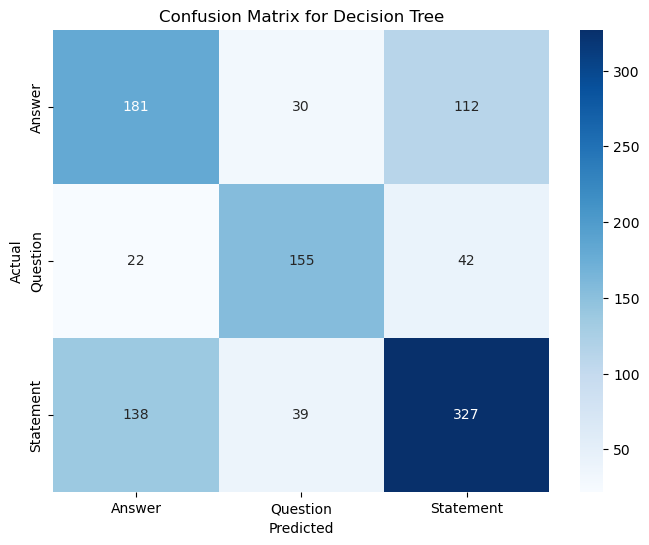

In [7]:
# Function to train and evaluate Decision Tree
def run_decision_tree(X_train, X_test, y_train, y_test, label_encoder):
    model = DecisionTreeClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Results for Decision Tree:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Decision Tree")

# Call the updated function
run_decision_tree(X_train, X_test, y_train, y_test, label_encoder)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 40, 'criterion': 'entropy'}
Results for Decision Tree with RandomizedSearchCV:
Training Accuracy: 0.9766
Test Accuracy: 0.6176
Classification Report:
              precision    recall  f1-score   support

      Answer       0.50      0.52      0.51       323
    Question       0.73      0.73      0.73       219
   Statement       0.65      0.63      0.64       504

    accuracy                           0.62      1046
   macro avg       0.63      0.63      0.63      1046
weighted avg       0.62      0.62      0.62      1046



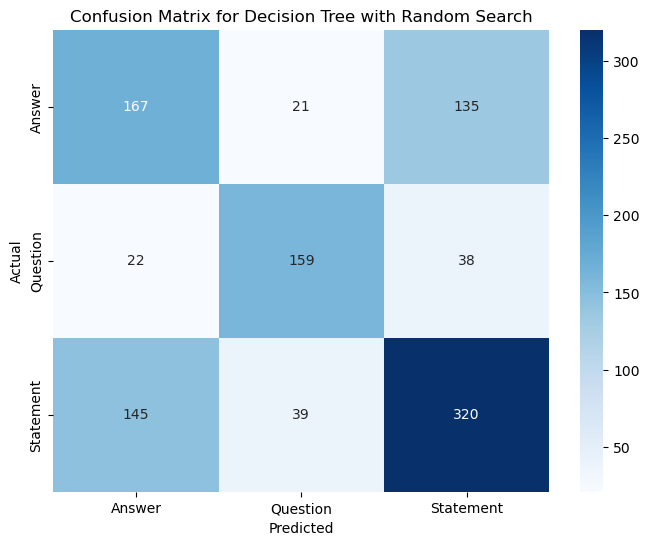

In [8]:
def run_decision_tree_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # Decision Tree model
    model = DecisionTreeClassifier()

    # Hyperparameter space for RandomizedSearchCV
    param_dist = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=50,  # number of iterations
        cv=5,       # cross-validation
        verbose=1,  # display progress
        n_jobs=-1,  # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print results
    print("Results for Decision Tree with RandomizedSearchCV:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Decision Tree with Random Search")

# Call the updated function
run_decision_tree_with_random_search(X_train, X_test, y_train, y_test, label_encoder)

Results for Random Forest:
Training Accuracy: 0.9926
Test Accuracy: 0.7141
Classification Report:
              precision    recall  f1-score   support

      Answer       0.62      0.48      0.54       323
    Question       0.91      0.82      0.86       219
   Statement       0.69      0.82      0.75       504

    accuracy                           0.71      1046
   macro avg       0.74      0.71      0.72      1046
weighted avg       0.71      0.71      0.71      1046



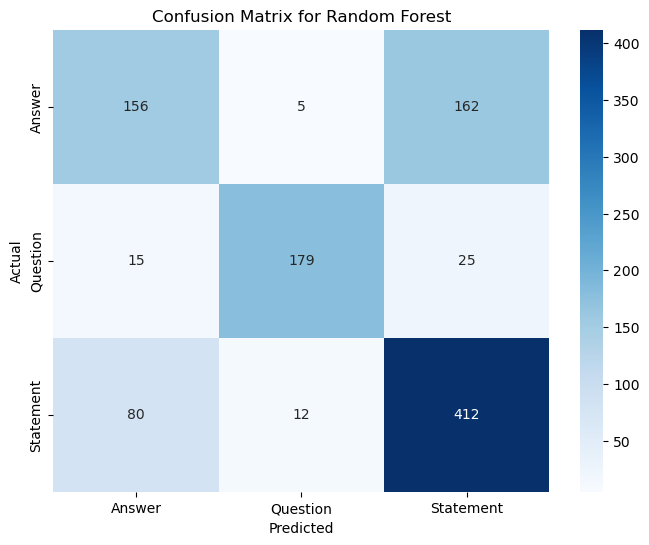

In [9]:
# Function to train and evaluate Random Forest
def run_random_forest(X_train, X_test, y_train, y_test, label_encoder):
    model = RandomForestClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Results for Random Forest:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Random Forest")

# Call the updated function
run_random_forest(X_train, X_test, y_train, y_test, label_encoder)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
Results for Random Forest with RandomizedSearchCV:
Training Accuracy: 0.9889
Test Accuracy: 0.7132
Classification Report:
              precision    recall  f1-score   support

      Answer       0.62      0.46      0.53       323
    Question       0.92      0.83      0.87       219
   Statement       0.68      0.82      0.75       504

    accuracy                           0.71      1046
   macro avg       0.74      0.71      0.72      1046
weighted avg       0.71      0.71      0.71      1046



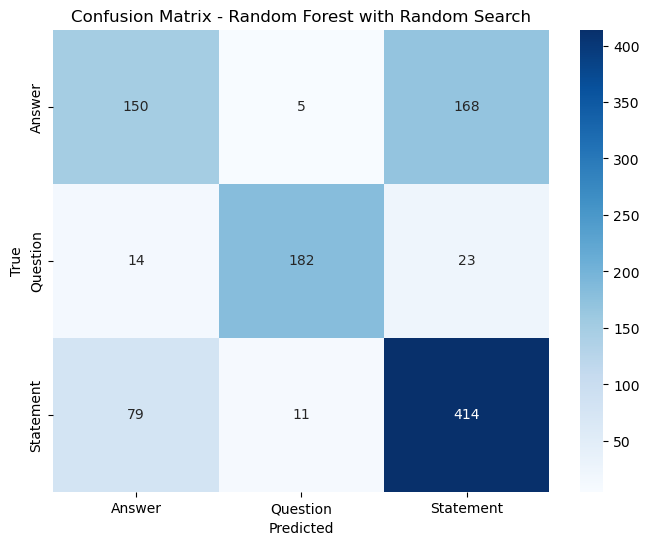

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, label_encoder, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Function to run Random Forest with RandomizedSearchCV
def run_random_forest_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # Random Forest model
    model = RandomForestClassifier()

    # Corrected hyperparameter space for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
        'max_features': ['sqrt', 'log2', None],     # Number of features to consider at every split
        'max_depth': [None, 10, 20, 30, 40],        # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required at each leaf node
        'bootstrap': [True, False]                  # Whether bootstrap samples are used when building trees
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=20,  # number of iterations (reduced for faster performance)
        cv=5,       # cross-validation
        verbose=1,  # display progress
        n_jobs=-1,  # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print results
    print("Results for Random Forest with RandomizedSearchCV:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Random Forest with Random Search")

# Call the updated function
run_random_forest_with_random_search(X_train, X_test, y_train, y_test, label_encoder)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost (Training Set):
Training Accuracy: 0.7298
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.57      0.48      0.52       670
    Question       0.95      0.91      0.93       549
   Statement       0.71      0.79      0.75      1220

    accuracy                           0.73      2439
   macro avg       0.74      0.73      0.73      2439
weighted avg       0.73      0.73      0.73      2439


Results for AdaBoost (Test Set):
Test Accuracy: 0.6711
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.56      0.44      0.49       323
    Question       0.88      0.77      0.82       219
   Statement       0.65      0.77      0.71       504

    accuracy                           0.67      1046
   macro avg       0.70      0.66      0.68      1046
weighted avg       0.67      0.67      0.67      1046



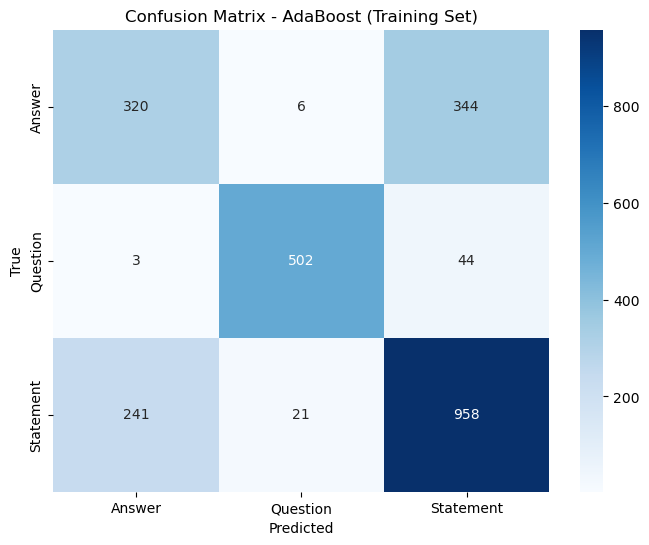

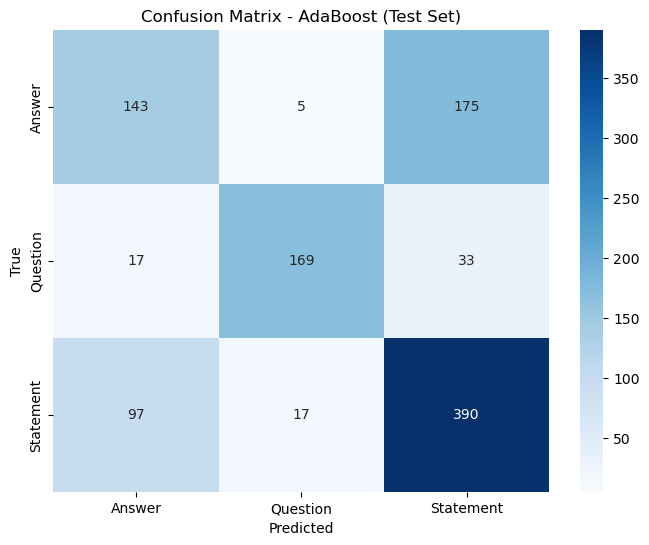

In [11]:
# Function to train and evaluate AdaBoost
def run_adaboost(X_train, X_test, y_train, y_test, label_encoder):
    model = AdaBoostClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the ›training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for AdaBoost (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for AdaBoost (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "AdaBoost (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "AdaBoost (Test Set)")

# Call the updated function
run_adaboost(X_train, X_test, y_train, y_test, label_encoder)

Results for XGBoost (Training Set):
Training Accuracy: 0.9926
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.99      0.99      0.99       670
    Question       1.00      1.00      1.00       549
   Statement       0.99      0.99      0.99      1220

    accuracy                           0.99      2439
   macro avg       0.99      0.99      0.99      2439
weighted avg       0.99      0.99      0.99      2439


Results for XGBoost (Test Set):
Test Accuracy: 0.7342
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.63      0.56      0.60       323
    Question       0.92      0.84      0.88       219
   Statement       0.72      0.80      0.76       504

    accuracy                           0.73      1046
   macro avg       0.76      0.73      0.74      1046
weighted avg       0.74      0.73      0.73      1046



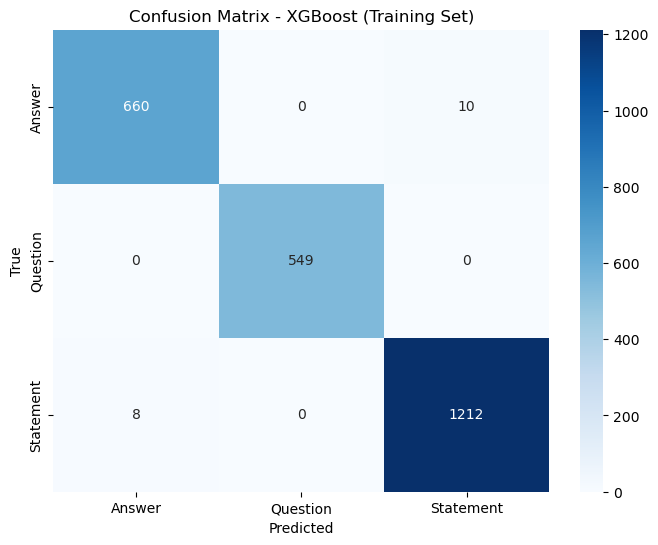

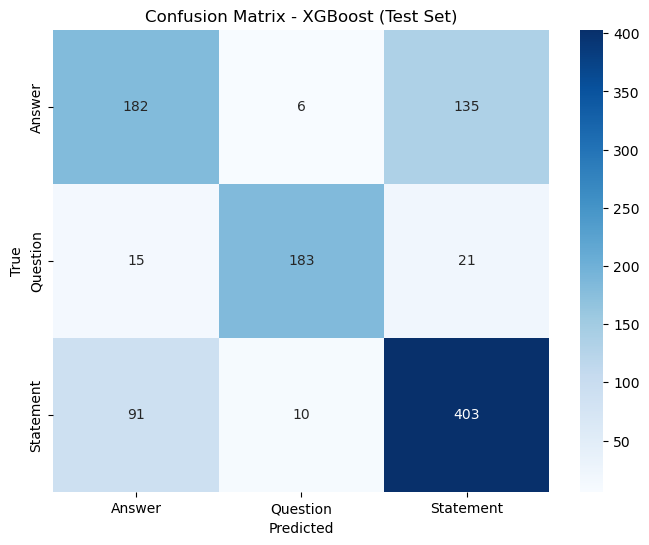

In [35]:
# Function to train and evaluate XGBoost
def run_xgboost(X_train, X_test, y_train, y_test, label_encoder):
    model = xgb.XGBClassifier(eval_metric='mlogloss')
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for XGBoost (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for XGBoost (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for the training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "XGBoost (Training Set)")
    
    # Plot confusion matrix for the test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "XGBoost (Test Set)")

# Call the updated function
run_xgboost(X_train, X_test, y_train, y_test, label_encoder)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Results for XGBoost with RandomizedSearchCV (Training Set):
Training Accuracy: 0.9926
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.99      0.99      0.99       670
    Question       1.00      1.00      1.00       549
   Statement       0.99      0.99      0.99      1220

    accuracy                           0.99      2439
   macro avg       0.99      0.99      0.99      2439
weighted avg       0.99      0.99      0.99      2439


Results for XGBoost with RandomizedSearchCV (Test Set):
Test Accuracy: 0.7304
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.63      0.55      0.59       323
    Question       0.92      0.83      0.87       219
   Statement       0.71      0.80      0.75    

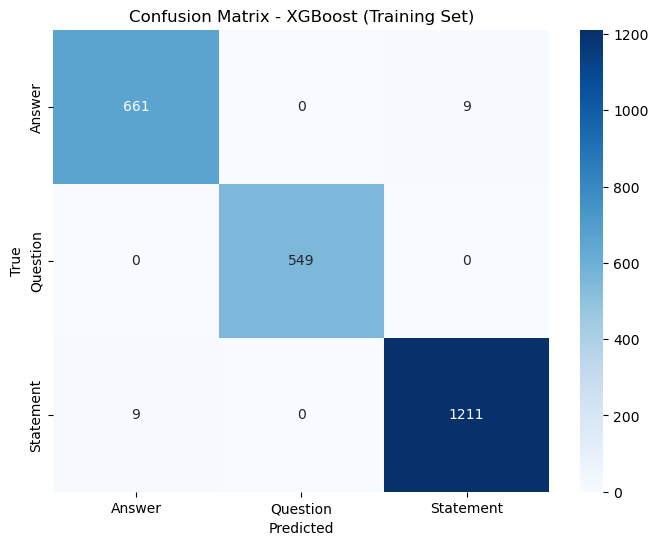

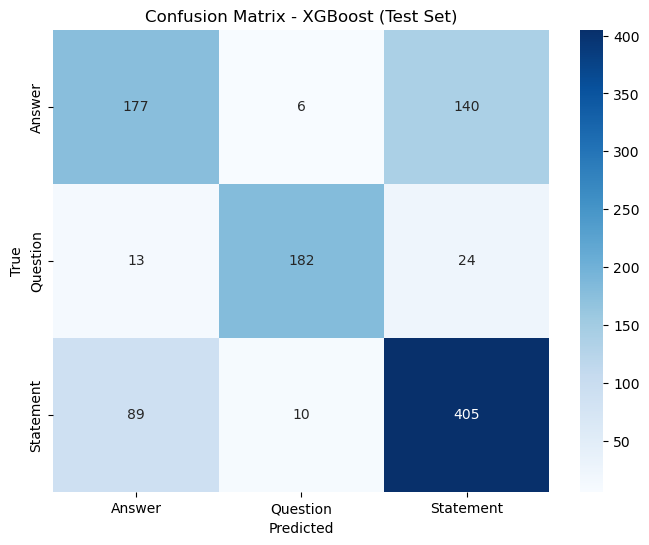

In [37]:

def run_xgboost_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # XGBoost model without use_label_encoder
    model = xgb.XGBClassifier(eval_metric='mlogloss')

    # Hyperparameter space for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],    # Number of trees
        'learning_rate': [0.01, 0.05, 0.1, 0.2],     # Step size shrinkage
        'max_depth': [3, 4, 5, 6, 7],                # Maximum depth of a tree
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],     # Subsample ratio of the training instance
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],           # Minimum loss reduction required to make a further partition on a leaf node
        'reg_alpha': [0, 0.01, 0.1, 1.0],           # L1 regularization term on weights
        'reg_lambda': [0.01, 0.1, 1.0]              # L2 regularization term on weights
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=50,   # number of iterations
        cv=5,        # cross-validation
        verbose=1,   # display progress
        n_jobs=-1,   # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print training results
    print("Results for XGBoost with RandomizedSearchCV (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for XGBoost with RandomizedSearchCV (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)

    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "XGBoost (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "XGBoost (Test Set)")

# Call the updated function
run_xgboost_with_random_search(X_train, X_test, y_train, y_test, label_encoder)

Results for KNN (Training Set):
Training Accuracy: 0.8200
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.74      0.72      0.73       670
    Question       0.85      0.94      0.90       549
   Statement       0.85      0.82      0.83      1220

    accuracy                           0.82      2439
   macro avg       0.81      0.83      0.82      2439
weighted avg       0.82      0.82      0.82      2439


Results for KNN (Test Set):
Test Accuracy: 0.7170
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.62      0.63      0.62       323
    Question       0.78      0.86      0.82       219
   Statement       0.76      0.71      0.73       504

    accuracy                           0.72      1046
   macro avg       0.72      0.73      0.72      1046
weighted avg       0.72      0.72      0.72      1046



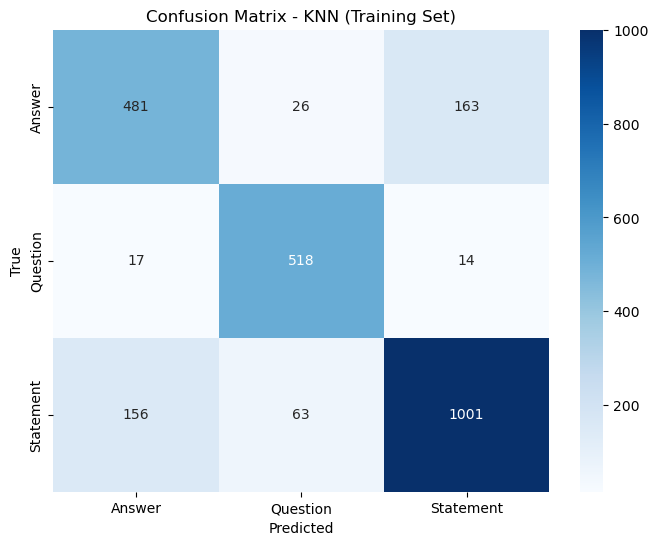

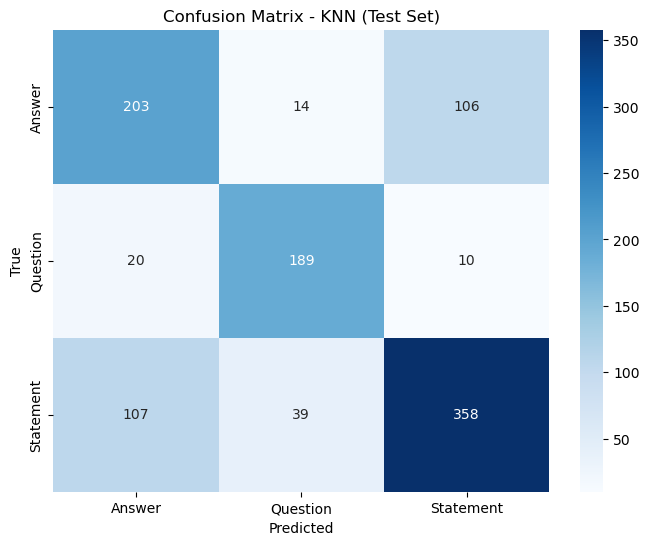

In [38]:
# Function to train and evaluate KNN
def run_knn(X_train, X_test, y_train, y_test, label_encoder):
    model = KNeighborsClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for KNN (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for KNN (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for the training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "KNN (Training Set)")
    
    # Plot confusion matrix for the test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "KNN (Test Set)")

# Call the updated function
run_knn(X_train, X_test, y_train, y_test, label_encoder)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'weights': 'distance', 'n_neighbors': 17, 'metric': 'manhattan'}
Results for KNN with Random Search (Training Set):
Training Accuracy: 0.9926
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.98      0.99      0.99       670
    Question       1.00      1.00      1.00       549
   Statement       1.00      0.99      0.99      1220

    accuracy                           0.99      2439
   macro avg       0.99      0.99      0.99      2439
weighted avg       0.99      0.99      0.99      2439


Results for KNN with Random Search (Test Set):
Test Accuracy: 0.7151
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.62      0.58      0.60       323
    Question       0.80      0.86      0.83       219
   Statement       0.73      0.74      0.74       504

    accuracy                           0.72      1046
   macro avg       0.72      0.73      0.72  

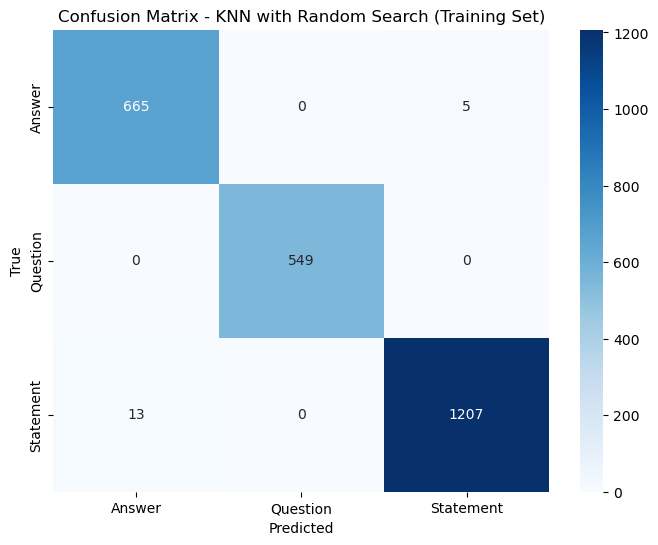

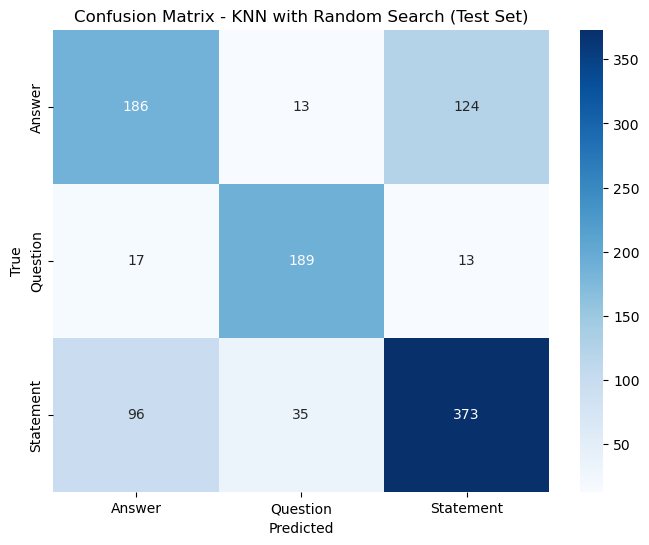

In [39]:
def run_knn_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    model = KNeighborsClassifier()

    # Define hyperparameter space for random search
    param_distributions = {
        'n_neighbors': np.arange(1, 31),  # Search for optimal number of neighbors between 1 and 30
        'weights': ['uniform', 'distance'],  # Uniform or distance-based weighting
        'metric': ['euclidean', 'manhattan', 'minkowski']  # Different distance metrics
    }

    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions, n_iter=20, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    # Best parameters found
    print("Best Parameters:", random_search.best_params_)

    # Evaluate the best model
    best_model = random_search.best_estimator_

    # Predictions on the test set
    y_pred_test = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)

    # Predictions on the training set
    y_pred_train = best_model.predict(X_train)
    train_accuracy = best_model.score(X_train, y_train)

    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print training results
    print("Results for KNN with Random Search (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)

    # Print test results
    print("\nResults for KNN with Random Search (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)

    # Plot confusion matrix for the training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "KNN with Random Search (Training Set)")

    # Plot confusion matrix for the test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "KNN with Random Search (Test Set)")

# Call the updated function
run_knn_with_random_search(X_train, X_test, y_train, y_test, label_encoder)

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular

def preprocess_data_with_bert(file_path):
    # Load the data
    df = pd.read_excel(file_path)
    
    # Ensure that 'Text' column is used as the independent variable
    df['Text'] = df['Text'].astype(str)
    
    # Drop any rows where 'Text' or 'Type' is NaN
    df.dropna(subset=['Text', 'Type'], inplace=True)
    
    # Define features and labels
    X = df['Text'].tolist()  # Convert the text to a list
    y = df['Type']
    
    # Encode the labels into numeric values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Load pre-trained BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    
    # Tokenize the input texts and convert them to token IDs
    def bert_tokenize(texts):
        return tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    
    # Generate BERT embeddings for the texts
    def get_bert_embeddings(texts):
        with torch.no_grad():  # Disable gradient calculations for inference
            inputs = bert_tokenize(texts)
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean of all token embeddings
        return embeddings
    
    # Generate embeddings for all the text data
    X_embeddings = get_bert_embeddings(X)
    
    # Convert PyTorch tensors to NumPy arrays
    X_embeddings = X_embeddings.numpy()
    
    # Split the data into training and test sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y_encoded, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder

# Preprocess data using BERT embeddings
file_path = 'test.xlsx'
X_train, X_test, y_train, y_test, label_encoder = preprocess_data_with_bert(file_path)

# Train a machine learning model (e.g., RandomForestClassifier)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Create a LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train, 
    feature_names=[f'feature_{i}' for i in range(X_train.shape[1])],
    class_names=label_encoder.classes_, 
    mode='classification'
)

# Pick a test instance to explain
instance_to_explain = X_test[0]

# Generate explanation for the instance
exp = explainer.explain_instance(instance_to_explain, clf.predict_proba, num_features=10)

# Display explanation
exp.show_in_notebook()
